In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-urdu/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-urdu/classification')

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,headline,label
0,سچن تیندولکر کا وراٹ کوہلی کو مشورہ، یہ غلطی ک...,cricket
1,گریٹر نوئیڈا میں ماں بیٹی کا سفاکانہ قتل، معام...,crime
2,عصمت چغتائی کے 107 ویں یوم پیدائش پر گُوگل کا ...,entertainment
3,فلم اسٹار انوپم کھیر فلم اینڈ ٹیلی ویژن انسٹی ...,entertainment
4,جموں۔ کشمیر: 9 سالہ بچی کی اجتماعی عصمت دری کے...,crime


In [7]:
valid_df = pd.read_csv(path/'valid.csv')
valid_df.head()

,headline,label
0,اسٹائلش بیٹی جھاہنوی کپور کے ساتھ کچھ اس انداز...,entertainment
1,کٹرینہ کیف نے کہا : دیپکا نے اپنی شادی میں مجھ...,entertainment
2,نیوزی لینڈ کے خلاف تیسرے فیصلہ کن ٹیسٹ میچ میں...,cricket
3,باپ بنے شاہد ، گھر آئی ننھی پری,entertainment
4,مشہور فلم اداکار کمل ہاسن سیڑھیوں سے گر کر زخم...,entertainment


In [8]:
print('In Training data:')
for cls in train_df['label'].unique():
    print(cls, (train_df['label'] == cls).sum())

In Training data:
cricket 1168
crime 453
entertainment 2110


In [9]:
print('In Validation data:')
for cls in valid_df['label'].unique():
    print(cls, (valid_df['label'] == cls).sum())

In Validation data:
entertainment 536
cricket 290
crime 107


In [10]:
train_df['headline'][0]

'سچن تیندولکر کا وراٹ کوہلی کو مشورہ، یہ غلطی کبھی مت کرنا، تباہ ہو جائے گا کیرئیر'

In [11]:
train_df.shape, valid_df.shape

((3731, 2), (933, 2))

In [12]:
train_df[train_df['headline'].isnull()].shape, valid_df[valid_df['headline'].isnull()].shape

((0, 2), (0, 2))

In [13]:
label_cols = list(range(1,train_df.shape[1]))

In [14]:
print(label_cols)

[1]


In [15]:
id_to_col = list(train_df.columns)

In [16]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [20]:
class UrduTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/urdu_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [21]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/urdu_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [22]:
# 30,000 is the vocab size that we chose in sentencepiece
urdu_vocab = Vocab(itos)

In [23]:
tokenizer = Tokenizer(tok_func=UrduTokenizer, lang='ur')

In [24]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [25]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=urdu_vocab, bs=16)

In [26]:
data_lm.save()

In [27]:
data_lm.show_batch()

idx,text
0,▁کے ▁ذریعہ ▁اردو ادیب ہ ▁کو ▁خراج ▁عقیدت ▁ xx bo s ▁فلم ▁اسٹار ▁ان وپ م ▁کھیر ▁فلم ▁اینڈ ▁ٹیلی ▁ویژن ▁انسٹی ▁ٹیوٹ ▁آف ▁انڈیا ▁کے ▁چیئرمین ▁مقرر ▁ xx bo s ▁جموں ۔ ▁کشمیر : ▁9 ▁سالہ ▁بچی ▁کی ▁اجتماعی ▁عصمت ▁دری ▁کے ▁بعد ▁آنکھیں ▁نکال ▁کر ▁جسم ▁پر ▁چھڑک ا ▁تیزاب ▁ xx bo s ▁بال ▁بال ▁بچ ▁گئے ▁نمبر ▁ایک ▁گیند ▁باز ▁جس پر یت ▁بم
1,▁اور رب اڈا ▁سے ▁شین ▁ واٹسن ▁کی ▁بحث ▁ xx bo s ▁ورن ▁دھون ▁فلم ▁کے ▁لئے ▁32 ▁کروڑ ▁روپے ▁فیس ▁لیں ▁گے ▁ xx bo s ▁شاہد ▁کے ▁لئے ▁بیوی ▁میرا ▁نے ▁سالگرہ ▁سے ▁پہلے ▁دی ▁شاندار ▁پارٹی ▁ xx bo s ▁اپنے ▁کپڑوں ▁کو ▁لے ▁کر ▁ٹرو ل ▁ہوئی ▁ا جے ▁دیو گن ▁کی ▁بیٹی ، ▁والد ▁نے ▁دیا ▁منہ ▁توڑ ▁جواب ▁ xx bo s ▁آسٹریلیا
2,▁کر ▁حاصل ▁کیا ▁پہلا ▁مقام ▁ xx bo s ▁اترپردیش ▁: ▁دوسری ▁شادی ▁کرنے ▁کیلئے ▁شوہر ▁نے ▁پانچ ▁ماہ ▁کی ▁حامل ہ ▁بیوی ▁کو ▁فون ▁پر ▁دیا ▁تین ▁طلاق ▁ xx bo s ▁بگ ▁بجٹ ▁کی ▁فلموں ▁کا ▁دور ▁کبھی ▁ختم ▁نہیں ▁ہوگا ▁: ▁ا جے ▁دیو گن ▁ xx bo s ▁ا ڑتا ▁پنجاب ▁نے ▁کی ▁پہلے ▁8 ▁دنوں ▁میں ▁50 ▁کروڑ ▁روپ ئے ▁کی ▁کمائی ▁ xx bo
3,▁بنائی ▁ xx bo s ▁ایشیا ▁کپ ▁کے ▁بعد ▁بنگلہ ▁دیشی ▁کھلاڑی ▁ لٹن ▁داس ▁کا ▁پھر ▁دھ ماک ہ ▁ ، ▁بنائی ▁طوفان ی ▁ڈبل ▁سنچری ▁ ، ▁لگائے ▁32 ▁چوک ے ▁ xx bo s ▁افیم ▁کھلا ▁کر ▁خواتین ▁کی ▁آبروریزی ▁کرتا ▁تھا ▁ز انی ▁' جلی بی ' ▁بابا ، ▁فحش ▁ویڈیو ▁بناکر کرتا ▁تھا ▁بلیک ▁میل ▁ xx bo s ▁ٹی ▁وی ▁کی ▁سب ▁سے ▁ہاٹ
4,xx bo s ▁ٹی ▁ -20 ▁ٹیم ▁سے ▁باہر ہونے ▁کے ▁بعد ▁دھون ی ▁کو ▁پاکستان ▁سے ▁ملی ▁حمایت ▁ xx bo s ▁لکھنؤ ▁میں ▁سلمان ▁خان ▁کی ▁فلم ▁بجرنگ ی ▁بھائی ▁جان ▁کی ▁مخالفت ، ▁پوسٹر ▁جلائے ▁گئے ▁ xx bo s ▁والد ▁کی ▁تدفین ▁چھوڑ ▁کر ▁کرکٹ ▁کے ▁میدان ▁میں ▁اترا ▁افغانستان ▁کا ▁یہ ▁اسٹار ▁کھلاڑی ▁ ، ▁ٹیم ▁کو ▁جتا ▁کر ▁پیش ▁کیا ▁خراج ▁عقیدت ▁ xx


In [28]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [30]:
# Loading the pretrained language model on urdu wikipedia
learn.load(path/'../language-model/UrduDataset/models/fourth-ur-lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (3731 items)
x: LMTextList
▁ xx bo s ▁سچن ▁تین د ولکر ▁کا ▁ور اٹ ▁کو ہلی ▁کو ▁مشورہ ، ▁یہ ▁غلطی ▁کبھی ▁مت ▁کرنا ، ▁تباہ ▁ہو ▁جائے ▁گا ▁کیرئیر,▁ xx bo s ▁گریٹ ر ▁نوئیڈا ▁میں ▁ماں ▁بیٹی ▁کا ▁سفاک انہ ▁قتل ، ▁معاملہ ▁میں ▁ایف ▁آئی ▁آر ▁درج ، ▁تحقیقات ▁شروع,▁ xx bo s ▁عصمت ▁چغتائی ▁کے ▁107 ▁ویں ▁یوم ▁پیدائش ▁پر ▁گ ُ و گل ▁کا ▁ڈوڈ ل ▁کے ▁ذریعہ ▁اردو ادیب ہ ▁کو ▁خراج ▁عقیدت,▁ xx bo s ▁فلم ▁اسٹار ▁ان وپ م ▁کھیر ▁فلم ▁اینڈ ▁ٹیلی ▁ویژن ▁انسٹی ▁ٹیوٹ ▁آف ▁انڈیا ▁کے ▁چیئرمین ▁مقرر,▁ xx bo s ▁جموں ۔ ▁کشمیر : ▁9 ▁سالہ ▁بچی ▁کی ▁اجتماعی ▁عصمت ▁دری ▁کے ▁بعد ▁آنکھیں ▁نکال ▁کر ▁جسم ▁پر ▁چھڑک ا ▁تیزاب
y: LMLabelList
,,,,
Path: /home/gaurav/PycharmProjects/nlp-for-urdu/classification;

Valid: LabelList (933 items)
x: LMTextList
▁ xx bo s ▁اسٹائل ش ▁بیٹی ▁جھا ہ نو ی ▁کپور ▁کے ▁ساتھ ▁کچھ ▁اس ▁انداز ▁میں ▁نظر ▁آئیں ▁سری ▁دیوی,▁ xx bo s ▁کٹر ینہ ▁کی ف ▁نے ▁کہا ▁: ▁ دیپ کا ▁نے ▁اپنی ▁شادی ▁میں ▁مجھے ▁نہیں ▁بلایا ▁ xx re p ▁6 ▁۔,▁ xx bo s ▁نیوزی ▁لینڈ ▁کے 

In [31]:
# Fine tuning the prtrained LM on current dataset

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


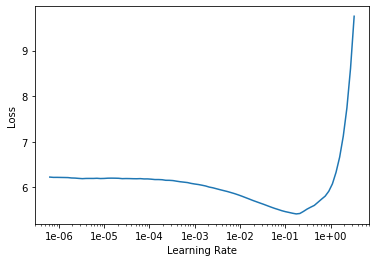

In [33]:
learn.recorder.plot()

In [34]:
learn.freeze()

In [35]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.939156,4.560511,0.304866,00:07


In [36]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.215203,4.218371,0.338036,00:08
1,3.863969,3.962980,0.370223,00:08
2,3.496485,3.869346,0.383348,00:08
3,3.201691,3.861648,0.390268,00:08
4,3.026298,3.871591,0.390625,00:07


In [38]:
learn.predict('سرحدی علاقے میں فوجی',n_words=10)

'سرحدی علاقے میں فوجی ▁افسر ▁کا ▁قتل ، ▁پولیس ▁نے ▁بلایا ▁گولیاں ، ▁چار'

In [39]:
learn.save_encoder('fine_tuned_enc')

In [40]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=urdu_vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [41]:
data_clas.show_batch()

text,target
▁ xx bo s ▁اذان ▁سے ▁متعلق ▁ٹو یٹ ▁پر ▁چو طرف ہ ▁تنقید ▁کے ▁بعد ▁سو نو ▁ نگ م ▁نے ▁دی ▁صفائی ▁ ، ▁کسی ▁کو ▁لگتا ▁ہے ▁کہ ▁پیغمبر ▁اسلام ▁کی ▁تنقید ▁کی ▁ ، ▁تو ▁میں ▁معافی ▁چاہتا ▁ہوں,entertainment
▁ xx bo s ▁ٹیم ▁انڈیا ▁کے ▁چیف ▁سل یکٹر ▁نے ▁کہا ▁: ▁اس ▁وجہ ▁سے ▁ریش بھ ▁پن ت ▁پر ▁دن یش ▁ کارتک ▁کو ▁دی ▁ترجیح ▁ ، ▁ورلڈ ▁کپ ▁اس کو اڈ ▁میں ▁ملی ▁جگہ,cricket
▁ xx bo s ▁ xx re p ▁6 ▁ . ▁جب ▁گر ل ▁فری نڈ ▁کے ▁گھر ▁ رومانس ▁کرنے ▁پہنچے ▁تھے ▁سلمان ، ▁لیکن ▁بیچ ▁میں ▁ہی ▁آگئے ▁تھے ▁گھر والے ▁پھر ▁جو ▁کچھ ▁ہوا ▁وہ,entertainment
"▁ xx bo s ▁جس پر یت ▁بم راہ ▁نے ▁پھینک ی ▁2018 ▁کی ▁سب ▁سے ▁"" حی رت ▁انگیز "" ▁گیند ▁ ، ▁آسٹریلیا ئی ▁ بلے ▁باز ▁کو ▁کچھ ▁نہیں ▁آیا ▁سمجھ ▁ ! ۔",cricket
▁ xx bo s ▁اب ▁تن و شری ▁– ▁نانا ▁تنازع ▁میں ▁کو د ▁پڑی ▁راج ▁ٹھاکر ے ▁کی ▁ایم ▁این ▁ایس ▁ ، ▁بگ ▁باس ▁سیٹ ▁توڑنے ▁کی ▁دی ▁دھمکی ▁ ، ▁جانیں ▁وجہ ▁ ؟,entertainment


In [42]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [43]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [44]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3731 items)
x: TextList
▁ xx bo s ▁سچن ▁تین د ولکر ▁کا ▁ور اٹ ▁کو ہلی ▁کو ▁مشورہ ، ▁یہ ▁غلطی ▁کبھی ▁مت ▁کرنا ، ▁تباہ ▁ہو ▁جائے ▁گا ▁کیرئیر,▁ xx bo s ▁گریٹ ر ▁نوئیڈا ▁میں ▁ماں ▁بیٹی ▁کا ▁سفاک انہ ▁قتل ، ▁معاملہ ▁میں ▁ایف ▁آئی ▁آر ▁درج ، ▁تحقیقات ▁شروع,▁ xx bo s ▁عصمت ▁چغتائی ▁کے ▁107 ▁ویں ▁یوم ▁پیدائش ▁پر ▁گ ُ و گل ▁کا ▁ڈوڈ ل ▁کے ▁ذریعہ ▁اردو ادیب ہ ▁کو ▁خراج ▁عقیدت,▁ xx bo s ▁فلم ▁اسٹار ▁ان وپ م ▁کھیر ▁فلم ▁اینڈ ▁ٹیلی ▁ویژن ▁انسٹی ▁ٹیوٹ ▁آف ▁انڈیا ▁کے ▁چیئرمین ▁مقرر,▁ xx bo s ▁جموں ۔ ▁کشمیر : ▁9 ▁سالہ ▁بچی ▁کی ▁اجتماعی ▁عصمت ▁دری ▁کے ▁بعد ▁آنکھیں ▁نکال ▁کر ▁جسم ▁پر ▁چھڑک ا ▁تیزاب
y: CategoryList
cricket,crime,entertainment,entertainment,crime
Path: /home/gaurav/PycharmProjects/nlp-for-urdu/classification;

Valid: LabelList (933 items)
x: TextList
▁ xx bo s ▁اسٹائل ش ▁بیٹی ▁جھا ہ نو ی ▁کپور ▁کے ▁ساتھ ▁کچھ ▁اس ▁انداز ▁میں ▁نظر ▁آئیں ▁سری ▁دیوی,▁ xx bo s ▁کٹر ینہ ▁کی ف ▁نے ▁کہا ▁: ▁ دیپ کا ▁نے ▁اپنی ▁شادی ▁میں ▁مجھے ▁نہیں ▁بلایا ▁ xx r

In [45]:
learn.freeze()

In [46]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


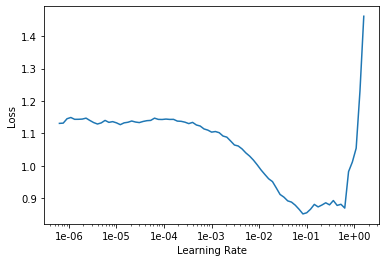

In [47]:
learn.recorder.plot()

In [48]:
learn.loss_func.func

CrossEntropyLoss()

In [49]:
kappa = KappaScore()

In [50]:
learn.metrics = [kappa, accuracy]

In [51]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.399098,0.261340,0.831009,0.906752,00:05


In [52]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.314623,0.227834,0.861681,0.923901,00:05


In [53]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.230087,0.207639,0.873792,0.930332,00:09
1,0.166221,0.178276,0.896265,0.942122,00:09
2,0.121720,0.193029,0.901641,0.945338,00:09
3,0.082160,0.178220,0.915816,0.952840,00:09
4,0.062471,0.183512,0.901693,0.945338,00:09


Better model found at epoch 0 with accuracy value: 0.9303322434425354.
Better model found at epoch 1 with accuracy value: 0.9421221613883972.
Better model found at epoch 2 with accuracy value: 0.9453375935554504.
Better model found at epoch 3 with accuracy value: 0.9528403282165527.


In [54]:
learn.predict('شاکنگ ایکسپریس وے میں خواتین کوچा')

(Category crime, tensor(1), tensor([0.2206, 0.4028, 0.3766]))

In [55]:
learn.predict("ایک موٹی بریک پر انسان کو چوروں میں موٹر سائیکل کھو دیتا ہے")

(Category crime, tensor(1), tensor([0.0082, 0.9809, 0.0110]))

In [56]:
learn.predict("کیا سلمان نے اپنا اپنا چینل بنایا؟")

(Category entertainment, tensor(2), tensor([0.0026, 0.0042, 0.9933]))

In [57]:
learn.predict("ڈھاما کیڈر! یہ ٹیم بھارت کے لئے بہترین کارکردگی ہےी")

(Category cricket, tensor(0), tensor([0.9588, 0.0012, 0.0400]))